In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
import PIVutils

In [2]:
#PIVutils = reload(PIVutils)
X, Y, U, V, Swirl, Cond, Prof = PIVutils.importMatlabPIVdata('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat',['X','Y','U','V','Swirl'],['Cond','Prof'])

In [3]:
frame = 1

In [4]:
NanLocs = np.isnan(Swirl)
uSize = Swirl.shape
scale = (X[1,-1]-X[1,1])/(uSize[1]-1)

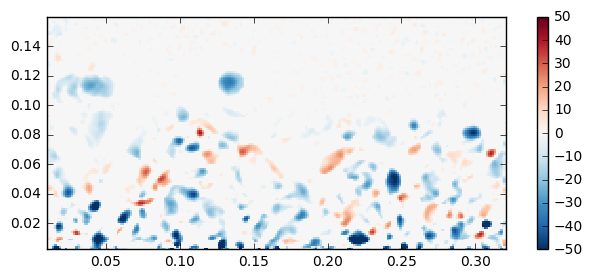

In [5]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(Swirl[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,50)

# Remove background noise

In [6]:
Noise = np.std(Swirl,axis=(2,1))
Noise = np.std(Noise[-5:])
print(Noise)

0.243960186268


In [7]:
SwirlFilt = Swirl.copy()    #think this should completely copy the list, allowing me to try things

#Swirl must be above a certain background value or it is zeroed
SwirlFilt[np.absolute(Swirl)<20*Noise] = 0

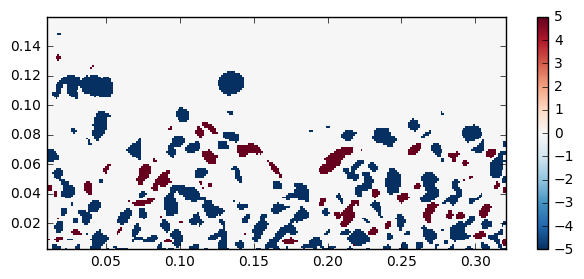

In [8]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,5)

# Normalize field by std

In [9]:
SwirlStd = np.std(Swirl,axis=(2,1))
#print(SwirlStd)

In [10]:
#Normalize field by the std of Swirl
SwirlFilt = SwirlFilt/SwirlStd.reshape(uSize[0],1,1) #match the SwirlStd length (123) with the correct index in Swirl (also 123)

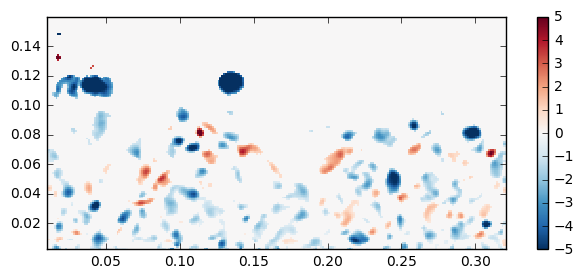

In [11]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5)

In [12]:
SwirlFiltBackup = SwirlFilt.copy()

# Create thresholded field

In [13]:
SwirlFilt = SwirlFiltBackup.copy()    #think this should completely copy the list, allowing me to try things

#Then only keep those locations where swirls is greater than Thresh*SwirlStd
ThreshSTD = 1.5
SwirlFilt[np.absolute(SwirlFilt)<ThreshSTD] = 0
SwirlFiltPro = SwirlFilt.copy()
SwirlFiltPro[SwirlFiltPro>0] = 0
SwirlFiltRet = SwirlFilt.copy()
SwirlFiltRet[SwirlFiltRet<0] = 0

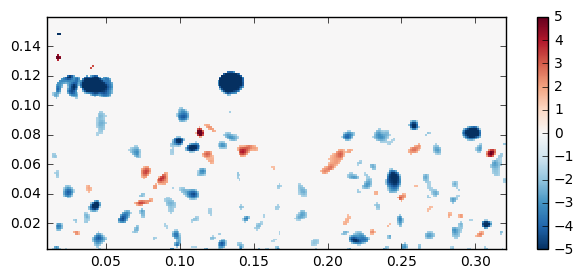

In [17]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5)

# Find all blobs and filter for size


In [20]:
PIVutils = reload(PIVutils)
ThreshPro = 35    #30 or 35 cause bug
[num_features_Pro,features_per_frame_Pro, labeled_array_Pro, cent_Pro] = PIVutils.findBlobs(SwirlFiltPro,ThreshPro)

ThreshRet = 20    #30 or 35 cause bug
[num_features_Ret,features_per_frame_Ret, labeled_array_Ret, cent_Ret] = PIVutils.findBlobs(SwirlFiltRet,ThreshRet)

There are  76730  features identified
A total of  13188  are larger than the threshold size
There are  27229  features identified
A total of  3924  are larger than the threshold size


In [ ]:
features_per_frame[frame]

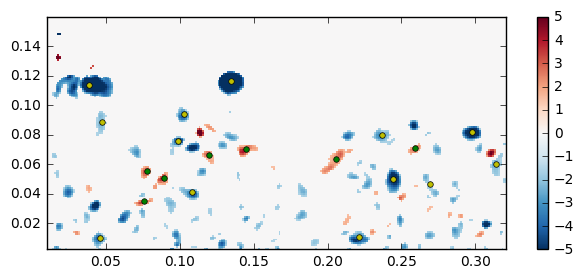

In [21]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5)

for i in range(features_per_frame_Pro[frame]):
    plt.plot(cent_Pro[frame][i][1]*scale+X[1,1],cent_Pro[frame][i][0]*scale+Y[1,1],'oy',markersize=4,markeredgecolor=None)
    
for i in range(features_per_frame_Ret[frame]):
    plt.plot(cent_Ret[frame][i][1]*scale+X[1,1],cent_Ret[frame][i][0]*scale+Y[1,1],'og',markersize=4,markeredgecolor=None)

# Subtract mean profile or mean at centroid of swirl blob

In [22]:
#Calculate mean velocity profiles
Umean = np.nanmean(U,axis=(2,1))
Umean
Umean.shape
#print(Umean)

Umean = np.transpose(np.tile(Umean,(uSize[2],uSize[1],1)),(2,1,0))
#print(Umean.shape)

#Subtract mean velocity profiles from velocity fields
Uf = U - Umean;
Vf = V; #<--Mean in vertical is aprox zero
#Wf = W
del Umean

# Find all thumbnails

In [25]:
BoxSize = 20     #turns out to half size of final box (box is 21 per side of BoxSize = 10)

Ut = np.zeros([2*BoxSize+1,2*BoxSize+1,num_features_Pro])    #initialize thumbnail matrices
Ut[:] = np.NAN
Vt = Ut.copy()
St = Ut.copy()
print(Ut.shape)


(41, 41, 13188)


In [26]:
#pad out velocity fields so that there are NaNs around in all directions
Uf2 = np.zeros([uSize[0]+2*BoxSize,uSize[1]+2*BoxSize+1,uSize[2]])    
Uf2[:] = np.NAN
Vf2 = Uf2.copy()
Sf2 = Uf2.copy()

print(Uf.shape)
print(Uf2.shape)

Uf2[BoxSize:-1*BoxSize,BoxSize:-1*BoxSize-1,:] = Uf.copy()
Vf2[BoxSize:-1*BoxSize,BoxSize:-1*BoxSize-1,:] = Vf.copy()
Sf2[BoxSize:-1*BoxSize,BoxSize:-1*BoxSize-1,:] = SwirlFiltPro.copy()

(123, 242, 750)
(163, 283, 750)


In [28]:
print(range(len(cent_Pro)))
print(np.sum(features_per_frame_Pro))

range(0, 750)
13188


In [30]:
#Round all centroids to integers
for i in range(len(cent_Pro)):
    for j in range(len(cent_Pro[i])):
        #print(i, j)
        cent_Pro[i][j] = (int(round(cent_Pro[i][j][0])), int(round(cent_Pro[i][j][1])))

/Users/Owen/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


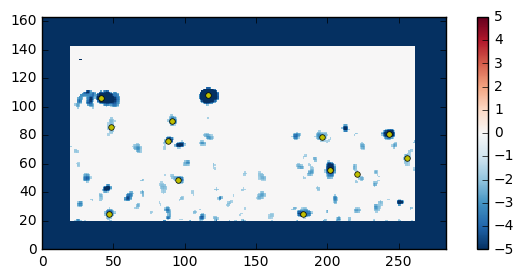

In [31]:
# Just to check, plot the new masked matrix to ensure its what we think it is. 
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(Sf2[:,:,frame],bound=5)

for i in range(features_per_frame_Pro[1]):
    plt.plot(cent_Pro[1][i][1]+BoxSize,cent_Pro[1][i][0]+BoxSize,'oy',markersize=4,markeredgecolor=None)

In [33]:
thumb = 0
for i in range(len(cent_Pro)):
    for j in range(len(cent_Pro[i])):
        
        Ut[:,:,thumb] = Uf2[cent_Pro[i][j][0]:cent_Pro[i][j][0]+2*BoxSize+1,cent_Pro[i][j][1]:cent_Pro[i][j][1]+2*BoxSize+1,i]  
        #print(cent[i][j][0])
        Vt[:,:,thumb] = Vf2[cent_Pro[i][j][0]:cent_Pro[i][j][0]+2*BoxSize+1,cent_Pro[i][j][1]:cent_Pro[i][j][1]+2*BoxSize+1,i] 
        St[:,:,thumb] = Sf2[cent_Pro[i][j][0]:cent_Pro[i][j][0]+2*BoxSize+1,cent_Pro[i][j][1]:cent_Pro[i][j][1]+2*BoxSize+1,i]  
        thumb+=1
        #print(thumb)
    

In [27]:
cent_Pro[i][j][0]

696

In [29]:
i

535

In [ ]:
[f, ax] = PIVutils.plotScalarField(St[:,:,0],bound=5)

# Get thumbnails as part of script

In [34]:
reload(PIVutils)
BoxSize = 20

Ut, Vt, St = PIVutils.getThumbnails2D(Uf,Vf,Swirl,cent_Pro,BoxSize)
Ut2, Vt2, St2 = PIVutils.getThumbnails2D(Uf,Vf,Swirl,cent_Ret,BoxSize)

/Users/Owen/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


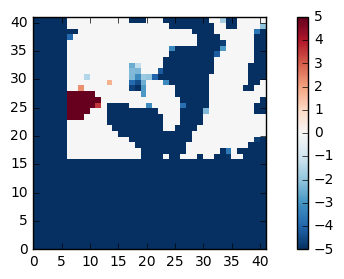

In [35]:
[f, ax] = PIVutils.plotScalarField(St[:,:,0],bound=5)

# Now do POD on the resulting thumbnails

In [36]:
#Set all NaNs to zero
Ut[np.isnan(Ut)] = 0
Vt[np.isnan(Vt)] = 0

uSize = Ut.shape

In [37]:
uAll = np.concatenate((Ut.reshape(uSize[0]*uSize[1],uSize[2]), Vt.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0)
#uAll.shape      

In [ ]:
import modred as mr

num_modes = 50;
modes, eig_vals = mr.compute_POD_matrices_snaps_method(uAll, list(range(num_modes)))

In [ ]:
menergy = eig_vals/np.sum(eig_vals)

In [ ]:
#Rearrange mode data to get mode fields
modeSize = modes.shape
Umodes = modes[0:uSize[0]*uSize[1],:];
Vmodes = modes[uSize[0]*uSize[1]:modeSize[0]+1,:];
Umodes.shape

#Umodes = np.reshape(Umodes,(uSize[0],uSize[1],num_modes))
Umodes2 = np.zeros((uSize[0],uSize[1],num_modes))
Vmodes2 = np.zeros((uSize[0],uSize[1],num_modes))

for i in range(num_modes):
    #i=1
    Umodes2[:,:,i] = np.reshape(Umodes[:,i],(uSize[0],uSize[1]))
    Vmodes2[:,:,i] = np.reshape(Vmodes[:,i],(uSize[0],uSize[1]))
    #Umodes.shape
    #uSize[0]*uSize[1]
    
Umodes = Umodes2 
Vmodes = Vmodes2
del Umodes2,Vmodes2

In [ ]:
import PODutil
PODutil.plotPODmodes2D(X[:2*BoxSize+1,:2*BoxSize+1],Y[:2*BoxSize+1,:2*BoxSize+1],Umodes,Vmodes,list(range(25)))